[Census API Datasets]('https://api.census.gov/data.html')
* ACS/Tiger Mapping files: https://www2.census.gov/geo/tiger/TIGER_DP/
* 2022 Relationship Files: https://www2.census.gov/geo/tiger/TIGER2022/

In [1]:
import pandas 
import json
import requests
import numpy
import os
import sys
import geopandas
import janitor
from path import Path

C:\Users\nanzawi\AppData\Local\anaconda3\Lib\site-packages\janitor\utils.py:84: FutureWarning: PandasArray has been renamed NumpyExtensionArray. Use that instead. This alias will be removed in a future version.
  @_expand_grid.register(pd.arrays.PandasArray)


In [2]:
# path configuration
working_directory = Path.getcwd()

inputs_path = working_directory / 'inputs'
outputs_path = working_directory / 'outputs'

In [3]:
# export function
def to_file(callback, desired_name, extension='csv'):
    current_files = sorted(outputs_path.files(desired_name + '*.' + extension))
    if current_files:
        last_file = current_files[-1]
        os.remove(last_file)
    final_name = '{}.{}'.format(desired_name, extension)
    callback(outputs_path / final_name)

In [4]:
def _geo_merge(frame,geo_frames_dictionary,geo):
    if isinstance(frame.columns, pandas.core.index.MultiIndex):
        frame.columns = [
            '-'.join(x)
            for x in frame.columns.values
        ]
    current_geo = geo_frames_dictionary[geo]
    with_geo = current_geo.merge(frame, left_index=True,right_index=True).drop('',errors='ignore')
    return with_geo

In [5]:
# capture geoid codes from url
geoid_codes = 'https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt'

# read in url and retain fips codes and names, set as string objects and index
state_fips = pandas.read_fwf(geoid_codes,skiprows=16,nrows=53,names=['FIPS Code','Name'],dtype={'FIPS Code': 'str'})
county_fips = pandas.read_fwf(geoid_codes,skiprows=73,names=['FIPS Code','Name'],dtype={'FIPS Code': 'str'})

# Define a function to apply str.title()
def title_col(df, column_name):
    df[column_name] = df[column_name].str.title()

# apply function and rename with appropriate geos
title_col(state_fips, 'Name')
title_col(county_fips, 'Name')

# rename column fips codes to appropriate geos

state_fips.rename(columns={'FIPS Code':'state'},inplace=True)
county_fips.rename(columns={'FIPS Code':'county'},inplace=True)

In [6]:
# make dictionaries
state_dict = state_fips.set_index('state')['Name'].to_dict()
county_dict = county_fips.set_index('county')['Name'].to_dict()

#### Upload Geos -------

In [7]:
# set mna crossings
mna_crossings_path =  Path(os.path.join(r"C:\Users\nanzawi\OneDrive - HDR, Inc\Data_Science\MODOT_RR\inputs\MoDOT_MNA_Crossings.xlsx"))

# grab shape files to merge to - if you want to grab from api
mo_blocks_shapefile = geopandas.read_file("https://www2.census.gov/geo/tiger/TIGER2022/BG/tl_2022_29_bg.zip")

# or if personal folder, grab and loop through
import glob

all_features = []

for geojson_file in glob.glob(os.path.join(inputs_path, 'Census*.geojson')):
    with open(geojson_file, 'r') as file:
        geojson_data = json.load(file)
        if 'features' in geojson_data:
            all_features.extend(geojson_data['features'])
            
merged_geojson = {
    'type': 'FeatureCollection',
    'features': all_features
}

output_file = 'merged.geojson'
with open(output_file, 'w') as outfile:
    json.dump(merged_geojson, outfile)

In [9]:
# read_file 
merged_blocks = geopandas.read_file('merged.geojson').clean_names()

### Example API

In [12]:
base_url = "https://api.census.gov/data"
dataset = "acs/acs5"
year = "2021"
variables = "B01001_001E"  # Population variable
state = "29"  # MO FIPS code  
counties = ["037","013","217","097","145","011"] # county FIPS codes for Jasper, Bates, Cass, Barton, Vernon
block_group = "*"  # All tracts within the county
api_key = "84c7d937e5b6038afeb17bd5615eceef179ff9a3"

In [13]:
data_per_county = {}

for county in counties:
    endpoint = f"{base_url}/{year}/{dataset}?get={variables}&for=block%20group:{block_group}&in=state:{state}&in=county:{county}&key={api_key}"

    response = requests.get(endpoint)
    if response.status_code == 200:
        data = response.json()
        data_per_county[county] = data
        # Process or handle data for each county here
        print(f"Data fetched for county {county}")
    else:
        print(f"Error fetching data for county {county}. Status code: {response.status_code}")

# You can process or aggregate data for each county within this loop.

Data fetched for county 037
Data fetched for county 013
Data fetched for county 217
Data fetched for county 097
Data fetched for county 145
Data fetched for county 011


In [14]:
# Convert the fetched data into pandas DataFrames for each county, skipping the first row
dataframes = {county: pandas.DataFrame(data[1:], columns=data[0]) for county, data in data_per_county.items()}

# Concatenate DataFrames
merged_dataframe = pandas.concat(dataframes.values(), keys=dataframes.keys())

display(
     merged_dataframe.head(),
     merged_dataframe.shape
)

B01001_001E state county   tract block group
037 0        1049    29    037  060001           1
    1        1258    29    037  060001           2
    2        2217    29    037  060001           3
    3         772    29    037  060003           1
    4         874    29    037  060003           2

(273, 5)

In [15]:
# create block group from fips codes to geoid
slim_df = merged_dataframe.copy()

slim_df['geoid'] = slim_df['state'] + slim_df['county'] + slim_df['tract'] + slim_df['block group']

In [16]:
# make geograpihes a string
slim_df[['state','county','tract']] = slim_df[['state','county','tract']].astype('str')

In [17]:
# add prefix to county name
slim_df['county'] = slim_df['state'] + slim_df['county']

# append  dictionary
slim_df = slim_df.replace({'county':county_dict,
                 'state':state_dict})

# change table name
slim_df.rename(columns={'B01001_001E':'total_population'},inplace= True)

In [18]:
# view
slim_df.head()

total_population     state       county   tract block group  \
037 0             1049  Missouri  Cass County  060001           1   
    1             1258  Missouri  Cass County  060001           2   
    2             2217  Missouri  Cass County  060001           3   
    3              772  Missouri  Cass County  060003           1   
    4              874  Missouri  Cass County  060003           2   

              geoid  
037 0  290370600011  
    1  290370600012  
    2  290370600013  
    3  290370600031  
    4  290370600032

In [41]:
# merge slim_df with spatial files on geoid
# geo_blockgroups = mo_blocks_shapefile.merge(slim_df, left_on='GEOID',right_on='geoid')

In [19]:
# You now make it for those that intersect the MNA - created with one mile buffer around each point
mna_crossings = pandas.read_excel(mna_crossings_path)

# view
mna_crossings.head()

,Zone Name,Zone ID,Address,Latitude,Longitude
0,Crossing 442989T,442989T,Mo 58 / 1St Street,38.782148,-94.271483
1,Crossing 442996D,442996D,E 199Th Street,38.755379,-94.308374
2,Crossing 442998S,442998S,Mo-Rt-P,38.734570,-94.322922
3,Crossing 443002M,443002M,S Ore Road,38.730762,-94.330520
4,Crossing 443003U,443003U,E 215Th Street,38.727629,-94.334531


In [20]:
# make mna points spatial
crs= '32610'

points = geopandas.GeoDataFrame(
    mna_crossings, crs=crs, geometry=geopandas.points_from_xy(mna_crossings.Longitude, mna_crossings.Latitude)
)

In [65]:
merged_blocks = merged_blocks.to_crs(points.crs)

In [24]:
buffer_miles = 1  # Define the buffer distance in miles

# Calculate the buffer distance in degrees (approximation: 1 degree ≈ 69 miles)
buffer_degrees = buffer_miles / 69.0

# Buffer the points in degrees
points['geometry'] = points.geometry.buffer(buffer_degrees)

In [25]:
# view these dataframes
display(
     points.head(),
     merged_blocks.head()
)

,Zone Name,Zone ID,Address,Latitude,Longitude,geometry
0,Crossing 442989T,442989T,Mo 58 / 1St Street,38.782148,-94.271483,"POLYGON ((-94.257 38.782, -94.257 38.781, -94...."
1,Crossing 442996D,442996D,E 199Th Street,38.755379,-94.308374,"POLYGON ((-94.294 38.755, -94.294 38.754, -94...."
2,Crossing 442998S,442998S,Mo-Rt-P,38.734570,-94.322922,"POLYGON ((-94.308 38.735, -94.308 38.733, -94...."
3,Crossing 443002M,443002M,S Ore Road,38.730762,-94.330520,"POLYGON ((-94.316 38.731, -94.316 38.729, -94...."
4,Crossing 443003U,443003U,E 215Th Street,38.727629,-94.334531,"POLYGON ((-94.320 38.728, -94.320 38.726, -94...."


,label,id,shid,prioritydatasources,total_population_per_square_mile,total_population,area_square_miles_,geometry
0,Block Group 290119601001,publicpolygonfeature:9:735756,country:us/state:mo/block_group:290119601001,"[ { ""label"": ""Total Population per square mile...",11.952516,1608,134.53234,"MULTIPOLYGON (((-94.24313 37.45519, -94.24315 ..."
1,Block Group 290119601002,publicpolygonfeature:9:735757,country:us/state:mo/block_group:290119601002,"[ { ""label"": ""Total Population per square mile...",8.898562,685,76.97873,"MULTIPOLYGON (((-94.07873 37.45080, -94.07988 ..."
2,Block Group 290119601003,publicpolygonfeature:9:735758,country:us/state:mo/block_group:290119601003,"[ { ""label"": ""Total Population per square mile...",87.081653,705,8.09585,"MULTIPOLYGON (((-94.07988 37.40712, -94.08208 ..."
3,Block Group 290119602001,publicpolygonfeature:9:735759,country:us/state:mo/block_group:290119602001,"[ { ""label"": ""Total Population per square mile...",8.514358,726,85.26773,"MULTIPOLYGON (((-94.30049 37.35450, -94.31126 ..."
4,Block Group 290119602002,publicpolygonfeature:9:735760,country:us/state:mo/block_group:290119602002,"[ { ""label"": ""Total Population per square mile...",7.314773,908,124.13235,"MULTIPOLYGON (((-94.61705 37.56706, -94.61770 ..."


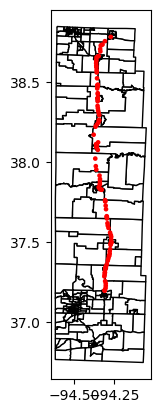

In [26]:
# view

base = merged_blocks.plot(color='white', edgecolor='black')

points.plot(ax=base, marker='o', color='red', markersize=5);

In [27]:
# calculate weighted population density

merged_blocks['weighted_population'] = merged_blocks['total_population'] * merged_blocks['total_population_per_square_mile']
merged_blocks['weighted_population_density'] = merged_blocks['weighted_population'] / merged_blocks['area_square_miles_']

In [45]:
# create areas of intersection

df_is = geopandas.overlay(merged_blocks, points, how='intersection')

# drop unnneeded columns
to_drop = ['id', 'shid', 'prioritydatasources','geometry']
df_is = pandas.DataFrame(df_is).drop(to_drop, axis=1)

C:\Users\nanzawi\AppData\Local\Temp\ipykernel_9464\963124207.py:3: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: EPSG:32610

  df_is = geopandas.overlay(merged_blocks, points, how='intersection')


In [47]:
# merge for analysis purposes
flat_file = df_is.groupby(['Zone Name','Zone ID','label','Address']).agg({
    'total_population_per_square_mile': 'sum',
    'total_population':'sum',
    'area_square_miles_':'sum',
    'weighted_population': 'sum',
    'weighted_population_density': 'mean'  # or any other aggregation function
}).reset_index()

In [56]:
merged_zones = df_is.groupby(['Zone Name','Zone ID','Latitude','Longitude']).agg({
    'total_population_per_square_mile': 'mean',
    'total_population':'mean',
    'area_square_miles_':'mean',
    'weighted_population': 'mean',
    'weighted_population_density': 'mean'  # or any other aggregation function
}).reset_index()

In [58]:
merged_zones.columns = merged_zones.columns.str.replace('total','avg').str.replace('weighted','avg_weighted').str.replace('area','avg_area')

In [59]:
merged_zones

,Zone Name,Zone ID,Latitude,Longitude,avg_population_per_square_mile,avg_population,avg_area_square_miles_,avg_weighted_population,avg_weighted_population_density
0,Crossing 442989T,442989T,38.782148,-94.271483,1173.587139,1387.333333,7.784625,1.957007e+06,2.292769e+06
1,Crossing 442996D,442996D,38.755379,-94.308374,68.809392,1638.500000,23.285135,1.221238e+05,5.030387e+03
2,Crossing 442998S,442998S,38.734570,-94.322922,68.809392,1638.500000,23.285135,1.221238e+05,5.030387e+03
3,Crossing 443002M,443002M,38.730762,-94.330520,86.003992,2184.000000,25.394170,1.878327e+05,7.396687e+03
4,Crossing 443003U,443003U,38.727629,-94.334531,86.003992,2184.000000,25.394170,1.878327e+05,7.396687e+03
...,...,...,...,...,...,...,...,...,...
106,Crossing 443263M,443263M,37.212847,-94.303996,34.231157,1246.500000,41.436155,5.671698e+04,1.652812e+03
107,Crossing 443266H,443266H,37.201876,-94.308529,196.323697,998.750000,21.838172,1.555432e+05,6.590742e+04
108,Crossing 443267P,443267P,37.198319,-94.309273,196.323697,998.750000,21.838172,1.555432e+05,6.590742e+04
109,Crossing 443268W,443268W,37.196049,-94.309813,196.323697,998.750000,21.838172,1.555432e+05,6.590742e+04


In [60]:
to_file(merged_zones.to_csv,'MoDOTMNA_ZoneCrossingsPopulationStats')

In [123]:
# Create a Pandas Excel writer using the ExcelWriter method
excel_writer = pandas.ExcelWriter('MoDOTMNA_ZoneCrossingsPopulationStats.xlsx', engine='xlsxwriter')

# Write the DataFrames to the ExcelWriter
df_list = [flat_file, merged_zones]
for i, df in enumerate(df_list):
    df.to_excel(excel_writer, sheet_name=f'df_{i}', index=False)

# Close the ExcelWriter to save the Excel spreadsheet
excel_writer.close()

### Example 2 - More Detailed Table Collection

In [229]:
# read in product table and create different api call

# path configuration
working_directory = Path.getcwd()
inputs_path = working_directory /'inputs'

# read in spreadsheet with table names
tables = pandas.read_excel(inputs_path/'2021_DataProductList.xlsx')

In [232]:
tables.head()

,Table ID,Table Title,Table Universe,Data Product Type,Year,1-Year Geography Restrictions\n(with Summary Levels in Parentheses),5-Year Geography Restrictions\n(with Summary Levels in Parentheses)
0,B01001,SEX BY AGE,Total population,Detailed Table,"1,5",NaN,NaN
1,B01001A,SEX BY AGE (WHITE ALONE),People who are White alone,Detailed Table,"1,5",NaN,Excludes Place/Remainder and Block Group geogr...
2,C01001A,SEX BY AGE (WHITE ALONE),People who are White alone,Detailed Table,1,NaN,NaN
3,B01001B,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),People who are Black or African American alone,Detailed Table,"1,5",NaN,Excludes Place/Remainder and Block Group geogr...
4,C01001B,SEX BY AGE (BLACK OR AFRICAN AMERICAN ALONE),People who are Black or African American alone,Detailed Table,1,NaN,NaN


In [267]:
# filter to see if there are table dems of interest

table_dems = list(tables['Table Universe'].unique())

# example - use keywords transportation and income and filter for table names

# get all tables for C0100A
group = list(tables[tables['Table ID'].str.contains('C01001')]['Table ID'].unique())

In [268]:
group

['C01001A',
 'C01001B',
 'C01001C',
 'C01001D',
 'C01001E',
 'C01001F',
 'C01001G',
 'C01001H',
 'C01001I']

In [277]:
# different API call - all sex by age

base_url = "https://api.census.gov/data"
dataset = "acs/acs5"
year = "2019"
variables = group  # Population variable
state = "06"  # California FIPS code
county = "073"  # Los Angeles County FIPS code
tract = "*"  # All tracts within the county
api_key = "84c7d937e5b6038afeb17bd5615eceef179ff9a3"

endpoint = f"{base_url}/{year}/{dataset}?get=group(B02015)&for=tract:{tract}&in=state:{state}&in=county:{county}&key={api_key}"